# Car Detection -- Fastai version

注意：这个笔记本是我在 kaggle 上训练的，如果您需要在 aistudio 上运行，请先安装 `fastai`。

建议您在 kaggle 上运行此笔记本，网址： https://www.kaggle.com/rsworktech/notebook0d735799b8

In [ ]:
!pip install fastai

安装 fastai 目标检测库

In [5]:
!pip install git+https://github.com/rbrtwlz/fastai_object_detection

  Cloning https://github.com/rbrtwlz/fastai_object_detection to /tmp/pip-req-build-nxnweq0t
  Running command git clone -q https://github.com/rbrtwlz/fastai_object_detection /tmp/pip-req-build-nxnweq0t
  Cloning https://github.com/bes-dev/mean_average_precision to /tmp/pip-install-jz02myam/mean-average-precision_c2310c9fa4ef40ef838409d42e575793
  Running command git clone -q https://github.com/bes-dev/mean_average_precision /tmp/pip-install-jz02myam/mean-average-precision_c2310c9fa4ef40ef838409d42e575793


准备数据集(如果您在 aistudio 上运行，则不需要运行下面两行代码，程序会自动下载数据集，如果数据集/模型下载失败请给 aistudio 环境挂上翻墙代理，总之还是推荐在 kaggle 上运行此笔记本)

In [6]:
!mkdir ~/.fastai/
!cp -r /kaggle/input/cardatasetpart-of-coco/fastai/* ~/.fastai

mkdir: cannot create directory ‘/root/.fastai/’: File exists


In [7]:
import torch
torch.cuda.is_available()

True

引入 Fastai 库函数

In [9]:
from fastai.vision.all import *
from fastai_object_detection.all import *

加载数据集

In [10]:
path, df = CocoData.create(ds_name="my-dataset", cat_list=["car", "bus","truck"], max_images=40000, with_mask=False)

Dataset my-dataset already exists: /root/.fastai/data/my-dataset


定义深度学习的数据加载器，batch size 设为 8，图片全部缩放到 800\*800 尺寸

In [11]:
dls = ObjectDetectionDataLoaders.from_df(df, bs=8, item_tfms=[Resize(800, method="pad", pad_mode="zeros")], batch_tfms=[Normalize.from_stats(*imagenet_stats)])

显示一批数据

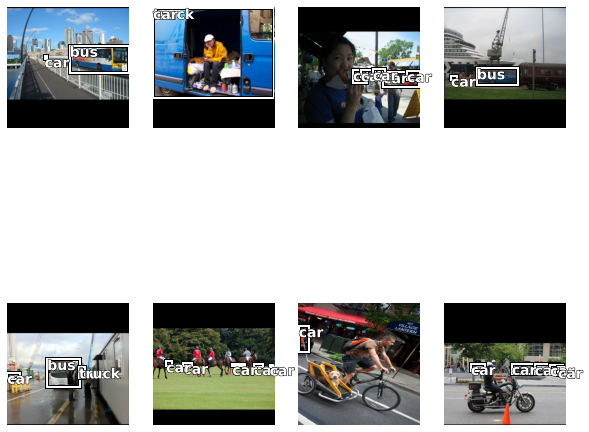

In [12]:
dls.show_batch(figsize=(10,10))

定义一个 faster R-CNN Learner, 采用 fasterrcnn_resnet50 网络（骨干网络为 resnet50）,基准学习率设为 0.005， weight decay 设为 0.0005，不对 BatchNorm 层进行训练，使用随机梯度下降优化器，使用 mAP@IoU>40% 和 mAP@IoU>60% 作为衡量。

In [13]:
learn = fasterrcnn_learner(dls, fasterrcnn_resnet50, opt_func=SGD, lr=0.005, wd=0.0005, train_bn=False,metrics=[mAP_at_IoU40, mAP_at_IoU60])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

冻结 Learner

In [14]:
learn.freeze()

查找较为合适的学习率

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.004365158267319202)

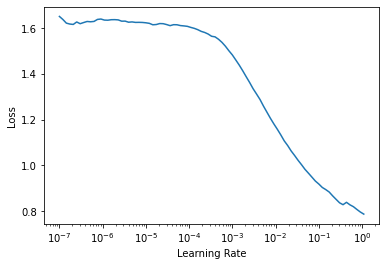

In [15]:
learn.lr_find()

使用此学习率作为初始学习率训练一轮

In [16]:
learn.fit_one_cycle(3, 0.004365158267319202)

epoch,train_loss,valid_loss,mAP@IoU>0.4,mAP@IoU>0.6,time
0,0.287485,0.306270,0.677120,0.609166,22:40
1,0.271889,0.296700,0.692938,0.622243,22:34
2,0.267027,0.297312,0.693729,0.625086,22:34


解冻 Learner

In [17]:
learn.unfreeze()

再训练一轮

In [18]:
learn.fit_one_cycle(3, 0.004365158267319202)

epoch,train_loss,valid_loss,mAP@IoU>0.4,mAP@IoU>0.6,time
0,0.275072,0.300329,0.695070,0.627571,35:55
1,0.269253,0.292425,0.714982,0.646891,35:36
2,0.267540,0.292534,0.713061,0.645600,35:40


保存模型（在 aistudio 上请更改为其他路径）

In [19]:
learn.save("/kaggle/working/car_detection_model")

Path('/kaggle/working/car_detection_model.pth')

显示结果

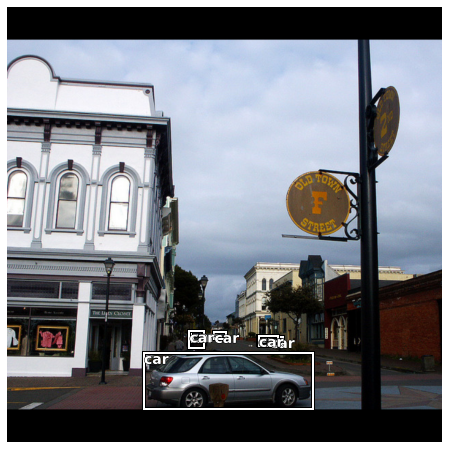

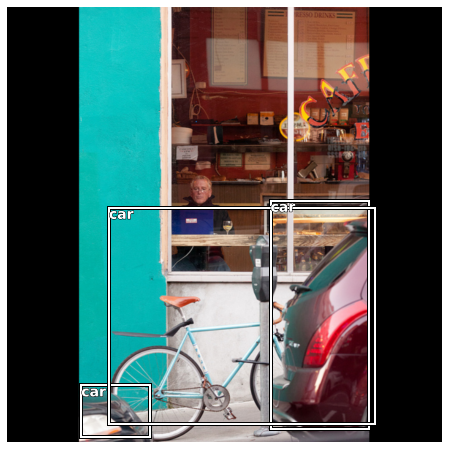

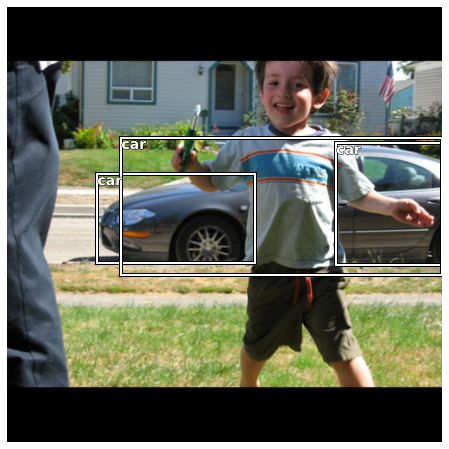

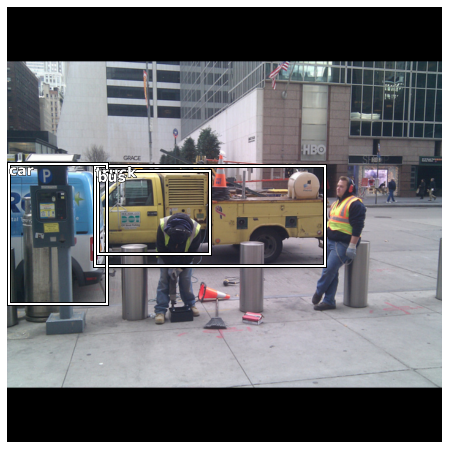

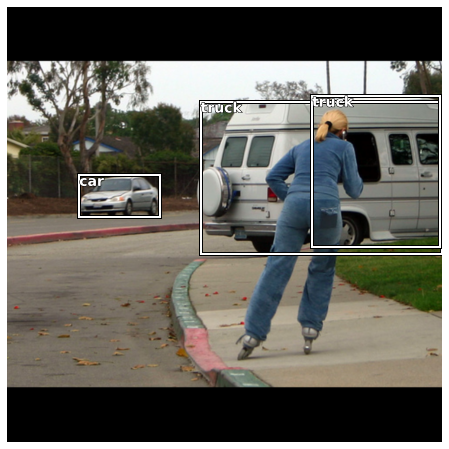

In [21]:
learn.show_results()

导出模型（在 aistudio 上请更改为其他路径）

In [22]:
learn.export("/kaggle/working/car_detection_model.pkl")

获得 pytorch 模型，方便导出

In [25]:
torch_model = learn.model.cpu().eval()

因为使用 CUDA 设备导出 onnx 模型时遇到问题，遂改用 cpu 设备

导出 onnx 模型（在 aistudio 上请更改为其他路径）

In [26]:
torch.onnx.export(torch_model, 
                  torch.randn(1,3,800,800),
                  "/kaggle/working/car_detection_model.onnx", 
                  do_constant_folding=True, export_params=True,
                 input_names=['image_1_3_800_800'], output_names=['boxes','classes','confidences'],
                 opset_version=11)

/opt/conda/lib/python3.7/site-packages/torch/tensor.py:593: RuntimeWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  'incorrect results).', category=RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float32)).float())) for i in range(dim)]
/opt/conda/lib/python3.7/site-packages/torchvision/models/detection/anchor_utils.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image_size[1] // g[1], dtype=torch.int64, devi

加载训练好的模型（在 aistudio 上请更改为对应模型保存路径）

In [35]:
learn_inf = load_learner("/kaggle/working/car_detection_model.pkl")

建立一个上传图片的控件

In [28]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

预测图像

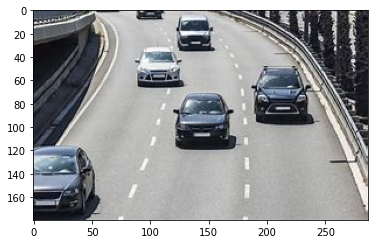

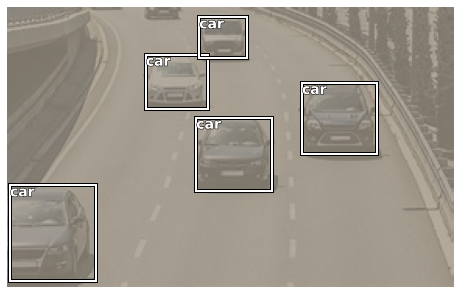

In [47]:
img = PILImage.create(btn_upload.data[-1])
plt.imshow(img)
learn.model.cuda()
learn.show_results([img])